# Extrapolation methods

 - Density estimation with Normalizing Flow
 - Unbinned Rerighting MC $\to$ data
 - ABCD

## Density estimation with Normalizing Flow

### Toy example

Use variables $\alpha$ and $\beta$ to define SR.

$$
p(\alpha) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

Use variable $y$ which is a function of $\alpha$ and $\beta$ for training and likelihood fitting.

$$
y = e^{- (\alpha + \beta)^2}
$$

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

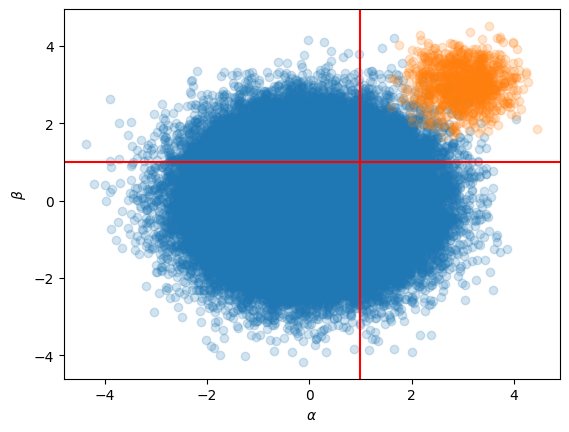

In [2]:
n1 = 100000
# Background
x1 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
x2 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.scatter(x1, x2, alpha = 0.2)
data = np.stack([x1, x2], axis = -1)
# Signal
n2 = 1000
x3 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
plt.scatter(x3, x4, alpha = 0.2)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.show

Blues shows the background events, and orange shows the signal events. The red lines define the CRs and SR. The upper right region is SR.

**Define the training model.**

In [3]:
def train(data):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[16,16], activation='sigmoid')
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data.ndim]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data.ndim,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)
    model.compile(optimizer=tf.optimizers.Adam(),loss=lambda _, log_prob: -log_prob)
    batch_size = 512

    # Train
    model.fit(x=data,
              y=np.zeros((len(data),0), dtype=np.float32),
              batch_size=batch_size,
              epochs=20,
              shuffle=True,
              verbose=True)
    # Predict the full background distribution
    samples = distribution.sample(data.shape)
    return samples 

**First, generate the 2D gaussian distribution.**

In [4]:
samples = train(data)

2023-01-24 13:44:42.931190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 13:44:45.268536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38277 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-01-24 13:44:45.272100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38277 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-01-24 13:44:45.273221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Epoch 1/20
 68/196 [=========>....................] - ETA: 0s - loss: 2.8997  

2023-01-24 13:44:49.360038: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 4s 2ms/step - loss: 2.8567
Epoch 2/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8340
Epoch 3/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8339
Epoch 4/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8339
Epoch 5/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8340
Epoch 6/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8342
Epoch 7/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8342
Epoch 8/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8340
Epoch 9/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8341
Epoch 10/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8340
Epoch 11/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8340
Epoch 12/20
196/196 [==============================] - 0s 1ms/step - loss: 2.8342
Epoch 13/20
196/196 [===============

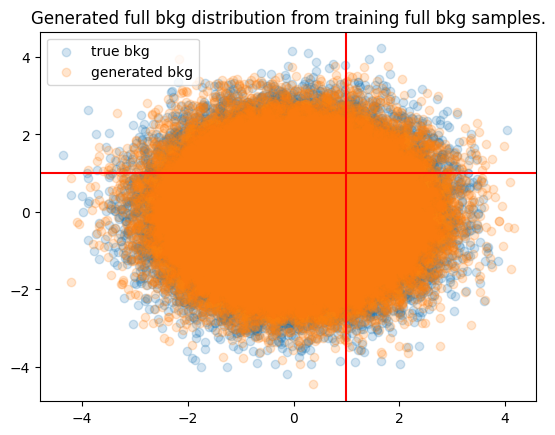

In [5]:
sample2 = samples[:,0]
y1 = sample2[:,0]
y2 = sample2[:,1]
plt.scatter(x1, x2, alpha = 0.2, label = 'true bkg')
plt.scatter(y1, y2, alpha = 0.2, label = 'generated bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.title("Generated full bkg distribution from training full bkg samples.")
plt.show()

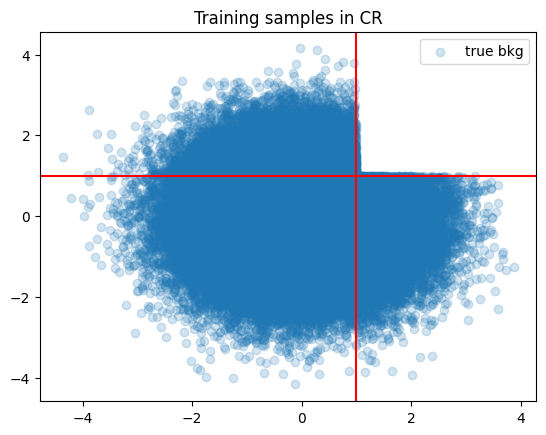

In [6]:
# Train on background distribution in CR
data2 = data[np.logical_not((data[:,0] > 1) & (data[:,1] > 1))]

# Plot partial background that's been trained on
x5 = data2[:,0]
x6 = data2[:,1]
plt.scatter(x5, x6, alpha = 0.2, label = 'true bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.title("Training samples in CR")
plt.legend()
plt.show()

In [7]:
samples = train(data2)

Epoch 1/20
191/191 [==============================] - 1s 2ms/step - loss: 2.8409
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7888
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7882
Epoch 4/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7878
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7879
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7879
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7879
Epoch 8/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7879
Epoch 9/20
191/191 [==============================] - 0s 1ms/step - loss: 2.7877
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7876
Epoch 11/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7877
Epoch 12/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7878
Epoch 13/20
191/191 [====

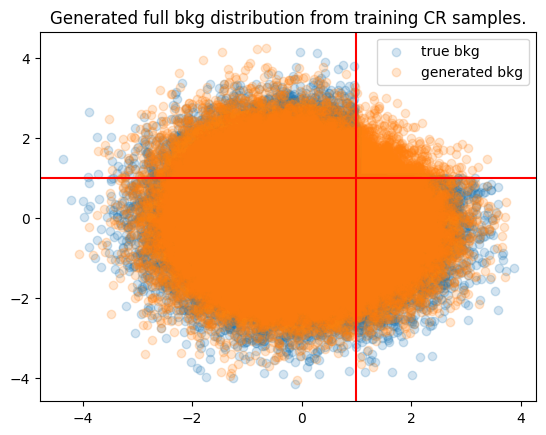

In [8]:
sample2 = samples[:,0]
y1 = sample2[:,0]
y2 = sample2[:,1]
plt.scatter(x5, x6, alpha = 0.2, label = 'true bkg')
plt.scatter(y1, y2, alpha = 0.2, label = 'generated bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.title("Generated full bkg distribution from training CR samples.")
plt.show()

**Now, generate $y = e^{- (\alpha + \beta)^2}$ with a conditioned density estimator.**

<function matplotlib.pyplot.show(close=None, block=None)>

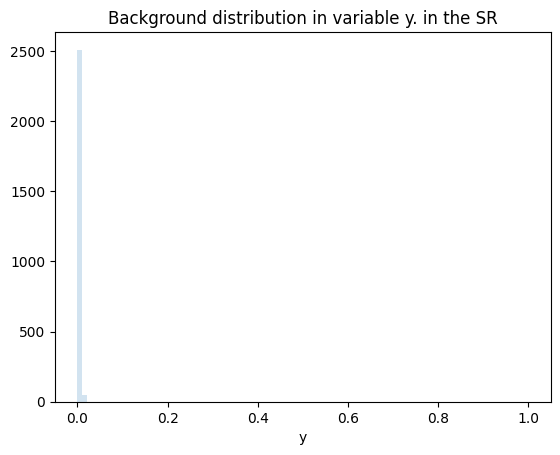

In [45]:
Y = np.exp(-(x1+x2)**2)
mask_gen =(x1> 1) & (x2 > 1)
Y_plot=Y[mask_gen]
bins = np.linspace(0.0, 1.0, 100)
plt.hist(Y_plot, bins, alpha = 0.2)
plt.title("Background distribution in variable y. in the SR")
plt.xlabel("y")
plt.show

In [46]:
def train_conditioned(data,cond,batch_size=512,learning_rate=1e-3):
    mask_train = np.logical_not((cond[:,0] > 1) & (cond[:,1] > 1))
    mask_gen =(cond[:,0] > 1) & (cond[:,1] > 1)
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(
        params=2, 
        hidden_units=[16,16], 
        event_shape=(data.ndim,),
        conditional=True,
        activation='sigmoid',
        conditional_event_shape=(cond.ndim,)
    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data.ndim]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data.ndim,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond.ndim,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(
        x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_, c_], log_prob_)
    
    # Train
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss=lambda _, log_prob: -log_prob)
    model.fit(x=[data[mask_train], cond[mask_train]],
              y=np.zeros((len(data[mask_train]),0), dtype=np.float32),
              batch_size=batch_size,
              epochs=20,
              shuffle=True,
              verbose=True)
    # Predict the full background distribution
    samples = distribution.sample(
        cond[mask_gen].shape[0],
        bijector_kwargs={'conditional_input': cond[mask_gen]}
    )
    return samples 

In [47]:
samples = train_conditioned(Y,data)

Epoch 1/20
191/191 [==============================] - 1s 2ms/step - loss: 0.5872
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2528
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1218
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: -0.2794
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: -0.9822
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: -2.2588
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: -3.0274
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: -3.3991
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: -3.5975
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: -3.6588
Epoch 11/20
191/191 [==============================] - 0s 2ms/step - loss: -3.7497
Epoch 12/20
191/191 [==============================] - 0s 2ms/step - loss: -3.8747
Epoch 13/20
191/

<function matplotlib.pyplot.show(close=None, block=None)>

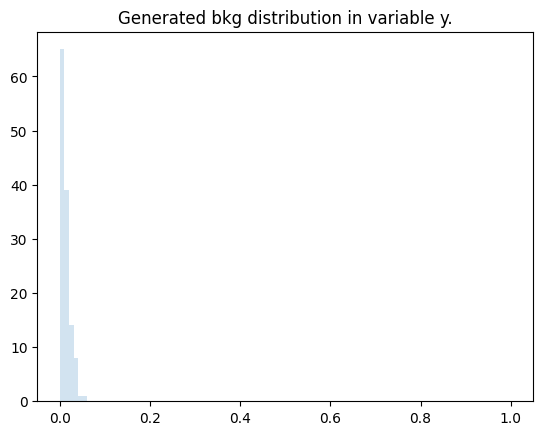

In [48]:
sample2 = samples.numpy()[:,0]
bins = np.linspace(0.0, 1.0, 100)
plt.hist(sample2, bins, alpha = 0.2)
plt.title("Generated bkg distribution in variable y.")
plt.show